In [3]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
import pydot
from sklearn.tree import export_graphviz # export decision tree
from sklearn.ensemble import RandomForestRegressor # build random forest
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to plot a classification tree
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

In [4]:
df = pd.read_csv('cdiabetes_data_upload.csv')

In [5]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [6]:
len(df.columns)

17

In [7]:
df.dtypes

Age                   int64
Gender                int64
Polyuria              int64
Polydipsia            int64
sudden weight loss    int64
weakness              int64
Polyphagia            int64
Genital thrush        int64
visual blurring       int64
Itching               int64
Irritability          int64
delayed healing       int64
partial paresis       int64
muscle stiffness      int64
Alopecia              int64
Obesity               int64
class                 int64
dtype: object

In [8]:
X = df.drop('class', axis=1).copy() 
X.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1


In [9]:
y = df['class'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [10]:
#split training set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#build decision tree
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

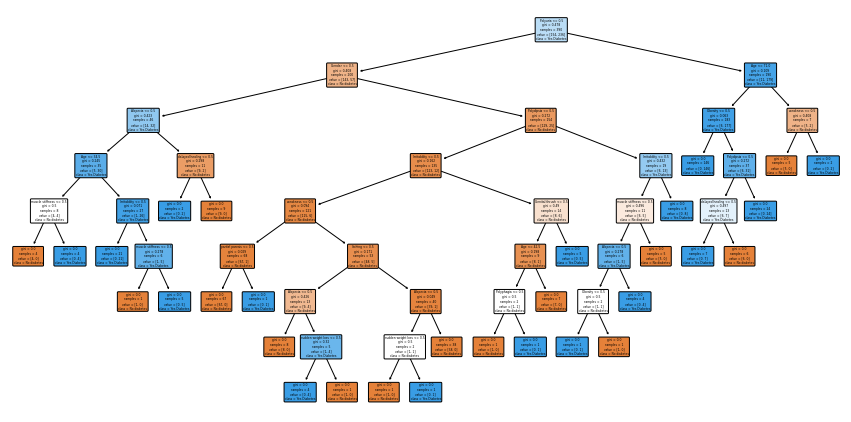

In [30]:
#plot the tree
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["No diabetes", "Yes Diabetes"],
         feature_names = X.columns);


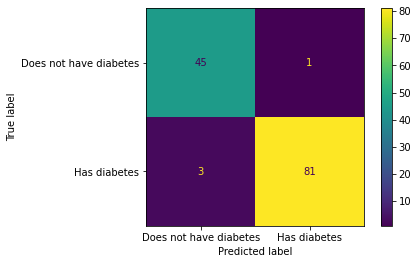

In [11]:
#decision tree method
plot_confusion_matrix(clf_dt, 
                      X_test, 
                      y_test, 
                      display_labels=["Does not have diabetes", "Has diabetes"])

In [12]:
#cost complexity pruning, to improve the accuracy of the dataset, since decision trees tend to overfit
#now we seek the alpha, except the maximum, -1, since it leaves us with the base root
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) #seeks alpha
ccp_alphas = path.ccp_alphas #all alphas
ccp_alphas = ccp_alphas[:-1] #except maximum

clf_dts = [] #an array 

In [13]:
print(ccp_alphas)

[0.         0.00213675 0.0022792  0.00246914 0.0025     0.00410256
 0.00503523 0.00732601 0.00838956 0.00839161 0.00851988 0.00992013
 0.01113324 0.01605799 0.01957463 0.0302716  0.05166313]


In [14]:
#decision tree of alphas (penalties)
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

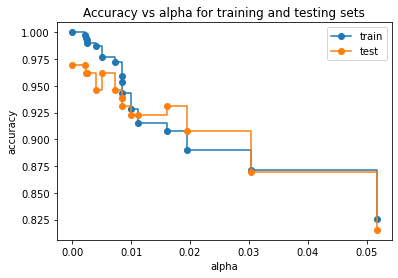

In [15]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o',label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o',label="test", drawstyle="steps-post")
ax.legend()
plt.show()
#since it's decision (classification) a tree, gini value ranges from 0 to 1

<AxesSubplot:xlabel='tree'>

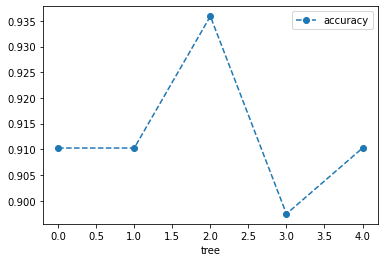

In [16]:
#using the plot above, I interpreted the best alpha by the intersection of the line
clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=0.009)
scores = cross_val_score(clf_dt, X_train, y_train, cv =5) #cv is fold, and 5 since dataset is small
df = pd.DataFrame(data={'tree':range(5),'accuracy':scores})
df.plot(x='tree', y='accuracy',marker='o',linestyle='--')
#the plot below verifies the consistentcy 

<AxesSubplot:xlabel='alpha'>

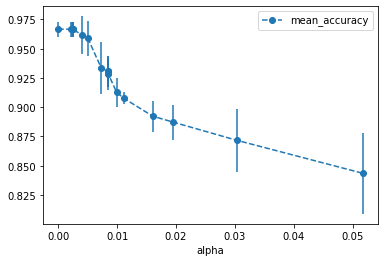

In [17]:
#finding optimal alpha
alpha_loop_values = [] #kernel to do cross-validation

#find moments of the alphas
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

#graph of the moments
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha',
                  y='mean_accuracy',
                  yerr='std',
                  marker='o',
                  linestyle='--')

In [18]:
#find exact results
alpha_results[(alpha_results['alpha'] < 0.01)]

,alpha,mean_accuracy,std
0,0.000000,0.966667,0.006281
1,0.002137,0.966667,0.006281
2,0.002279,0.966667,0.006281
3,0.002469,0.966667,0.006281
4,0.002500,0.966667,0.006281
5,0.004103,0.961538,0.016217
6,0.005035,0.958974,0.014951
7,0.007326,0.933333,0.022057
8,0.008390,0.930769,0.013074
9,0.008392,0.930769,0.013074


In [19]:
ideal_alpha = alpha_results[(alpha_results['alpha'] < 0.0025) & (alpha_results['alpha'] > 0.00247)]['alpha']
ideal_alpha

4    0.0025
Name: alpha, dtype: float64

In [20]:
ideal_alpha = float(ideal_alpha)
ideal_alpha

0.002499999999999998

In [21]:
clf_dt_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=ideal_alpha)
clf_dt_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.002499999999999998, random_state=0)

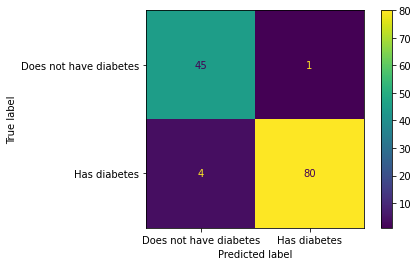

In [22]:
plot_confusion_matrix(clf_dt_pruned, 
                      X_test, 
                      y_test, 
                      display_labels=["Does not have diabetes", "Has diabetes"])

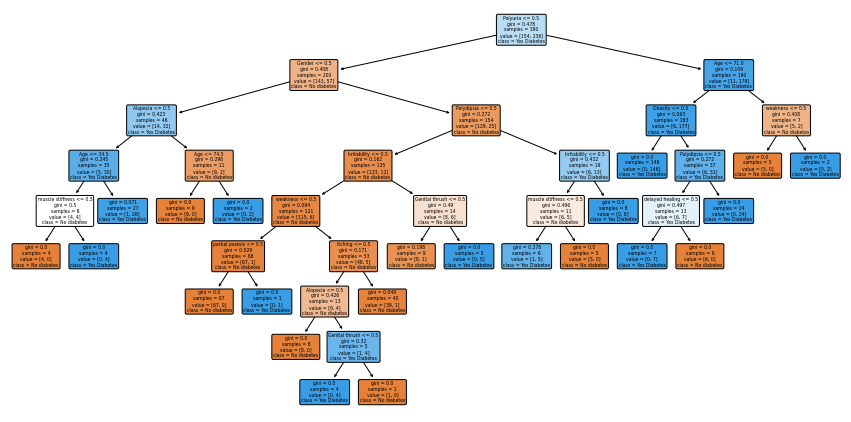

In [23]:
#plot the tree
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned,
         filled = True,
         rounded = True,
         class_names = ["No diabetes", "Yes Diabetes"],
         feature_names = X.columns);


In [24]:
#random forest method
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train);

In [25]:
predictions = rf.predict(X_test) #predict on test dataset
errors = abs(predictions - y_test)
print('Mean Absolute Error (MSE):', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error (MSE): 0.05 degrees.


In [26]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test).replace(np.inf, np.nan)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.45 %.


In [27]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [28]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [29]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Polyuria             Importance: 0.37
Variable: Polydipsia           Importance: 0.17
Variable: Gender               Importance: 0.1
Variable: Age                  Importance: 0.09
Variable: Alopecia             Importance: 0.06
Variable: Irritability         Importance: 0.05
Variable: delayed healing      Importance: 0.03
Variable: sudden weight loss   Importance: 0.02
Variable: Genital thrush       Importance: 0.02
Variable: muscle stiffness     Importance: 0.02
Variable: weakness             Importance: 0.01
Variable: Polyphagia           Importance: 0.01
Variable: visual blurring      Importance: 0.01
Variable: Itching              Importance: 0.01
Variable: partial paresis      Importance: 0.01
Variable: Obesity              Importance: 0.01


In [30]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features8
train_important = X_train[['Polyuria','Polydipsia']]
test_important = X_test[['Polyuria','Polydipsia']]
# Train the random forest
rf_most_important.fit(train_important, y_train)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

In [31]:
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.2 degrees.


In [32]:
# Display the performance metrics
nmape = (100 * (errors / y_test)).replace(np.inf,  np.nan)

In [35]:
theend = np.mean(nmape)

In [36]:
accuracy = 100 - theend
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 84.1 %.
